In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams["figure.dpi"] = 100
np.set_printoptions(precision=3, suppress=True)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler

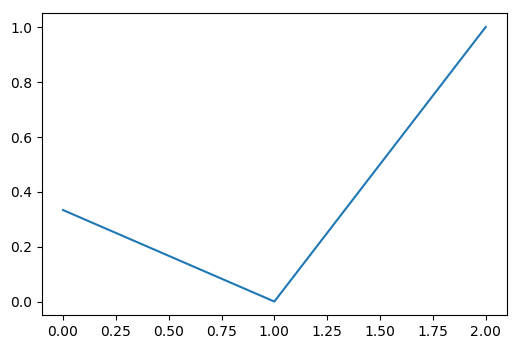

In [2]:
plt.plot([0, 1, 2], [1./3, 0, 1])

In [27]:
from sklearn.datasets import fetch_covtype
from sklearn.utils import check_array

def load_data(dtype=np.float32, order='C', random_state=13):
    ######################################################################
    # Load covertype dataset (downloads it from the web, might take a bit)
    data = fetch_covtype(download_if_missing=True, shuffle=True,
                         random_state=random_state)
    X = check_array(data['data'], dtype=dtype, order=order)
    # make it bineary classification
    y = (data['target'] != 1).astype(np.int)

    # Create train-test split (as [Joachims, 2006])
    n_train = 522911
    X_train = X[:n_train]
    y_train = y[:n_train]
    X_test = X[n_train:]
    y_test = y[n_train:]

    # Standardize first 10 features (the numerical ones)
    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0)
    mean[10:] = 0.0
    std[10:] = 1.0
    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = load_data()

# subsample training set by a factor of 10:
X_train = X_train[::10]
y_train = y_train[::10]

In [31]:
from sklearn.linear_model import LogisticRegressionCV
print(X_train.shape)
print(np.bincount(y_train))
lr = LogisticRegressionCV().fit(X_train, y_train)

(52292, 54)
[19036 33256]


In [29]:
lr.C_

array([ 2.783])

In [32]:
print(lr.predict_proba(X_test)[:10])
print(y_test[:10])

[[ 0.681  0.319]
 [ 0.049  0.951]
 [ 0.706  0.294]
 [ 0.537  0.463]
 [ 0.819  0.181]
 [ 0.     1.   ]
 [ 0.794  0.206]
 [ 0.676  0.324]
 [ 0.727  0.273]
 [ 0.597  0.403]]
[0 1 0 1 1 1 0 0 0 1]


In [34]:
from sklearn.calibration import calibration_curve
probs = lr.predict_proba(X_test)[:, 1]
prob_true, prob_pred = calibration_curve(y_test, probs, n_bins=5)
print(prob_true)
print(prob_pred)

[ 0.2    0.303  0.458  0.709  0.934]
[ 0.138  0.306  0.498  0.701  0.926]


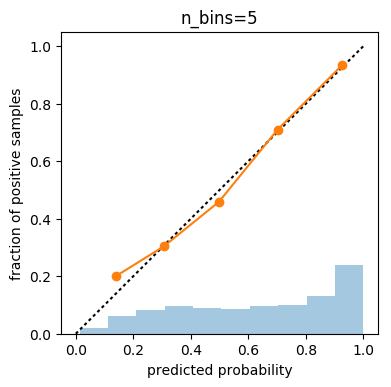

In [43]:
def plot_calibration_curve(y_true, y_prob, n_bins=5, ax=None, hist=True, normalize=False):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins, normalize=normalize)
    if ax is None:
        ax = plt.gca()
    if hist:
        ax.hist(y_prob, weights=np.ones_like(y_prob) / len(y_prob), alpha=.4,
               bins=np.maximum(10, n_bins))
    ax.plot([0, 1], [0, 1], ':', c='k')
    curve = ax.plot(prob_pred, prob_true, marker="o")

    ax.set_xlabel("predicted probability")
    ax.set_ylabel("fraction of positive samples")

    ax.set(aspect='equal')
    return curve

    
plot_calibration_curve(y_test, probs)
plt.title("n_bins=5")

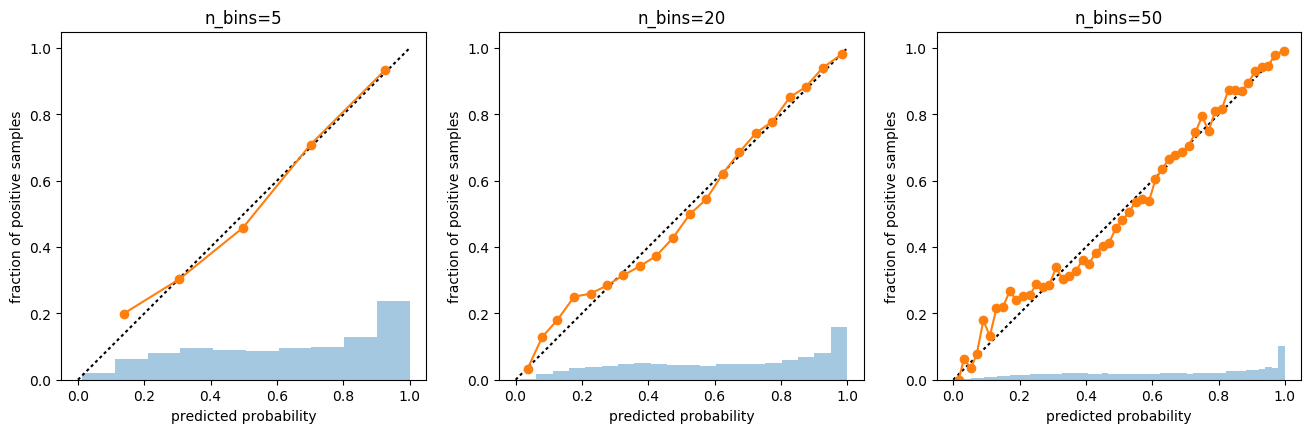

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
for ax, n_bins in zip(axes, [5, 20, 50]):
    plot_calibration_curve(y_test, probs, n_bins=n_bins, ax=ax)
    ax.set_title("n_bins={}".format(n_bins))

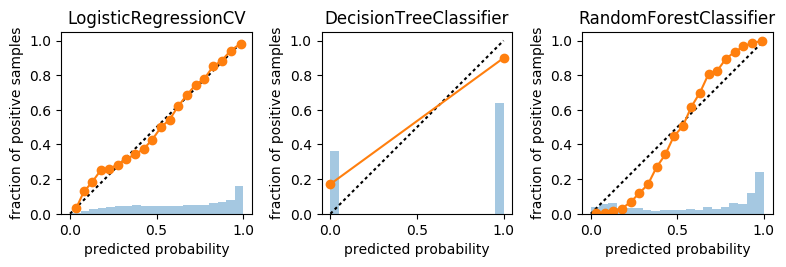

In [47]:
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
fig, axes = plt.subplots(1, 3, figsize=(8, 8))
for ax, clf in zip(axes, [LogisticRegressionCV(), DecisionTreeClassifier(),
                          RandomForestClassifier(n_estimators=100)]):
        # use predict_proba is the estimator has it
        scores = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
        plot_calibration_curve(y_test, scores, n_bins=20, ax=ax)
        ax.set_title(clf.__class__.__name__)

plt.tight_layout()

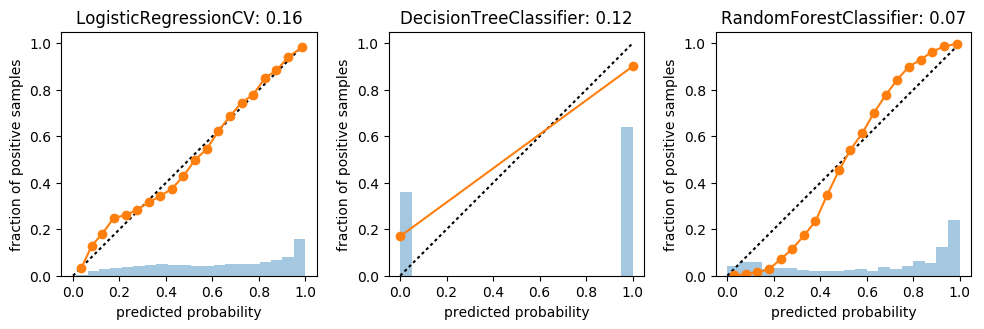

In [48]:
# same thing but with bier loss shown. Why do I refit the models? lol
from sklearn.metrics import brier_score_loss
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
for ax, clf in zip(axes, [LogisticRegressionCV(), DecisionTreeClassifier(), RandomForestClassifier(n_estimators=100)]):
        # use predict_proba is the estimator has it
        scores = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
        plot_calibration_curve(y_test, scores, n_bins=20, ax=ax)
        ax.set_title("{}: {:.2f}".format(clf.__class__.__name__, brier_score_loss(y_test, scores)))

plt.tight_layout()

In [50]:
from sklearn.calibration import CalibratedClassifierCV
X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train,
                                                          stratify=y_train, random_state=0)

In [65]:
rf = RandomForestClassifier(n_estimators=100).fit(X_train_sub, y_train_sub)
scores = rf.predict_proba(X_test)[:, 1]

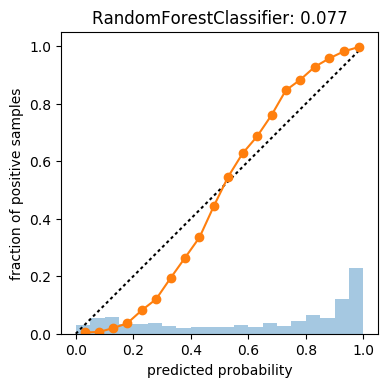

In [66]:
plot_calibration_curve(y_test, scores, n_bins=20)
plt.title("{}: {:.3f}".format(clf.__class__.__name__, brier_score_loss(y_test, scores)))

In [67]:
cal_rf = CalibratedClassifierCV(rf, cv="prefit", method='sigmoid')
cal_rf.fit(X_val, y_val)
scores_sigm = cal_rf.predict_proba(X_test)[:, 1]

cal_rf_iso = CalibratedClassifierCV(rf, cv="prefit", method='isotonic')
cal_rf_iso.fit(X_val, y_val)
scores_iso = cal_rf_iso.predict_proba(X_test)[:, 1]

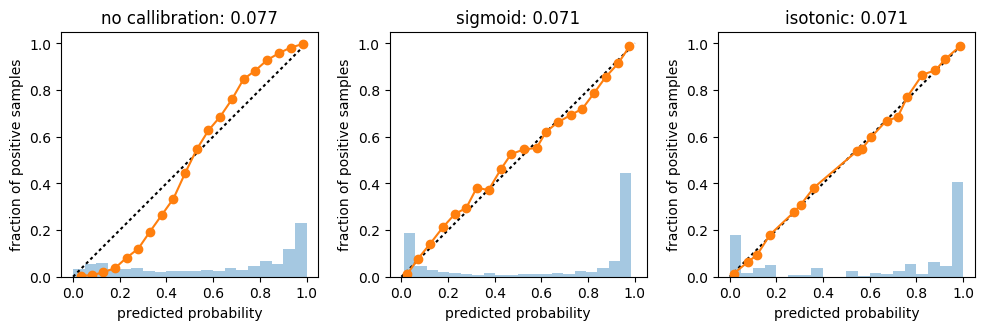

In [69]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

for name, s, ax in zip(['no callibration', 'sigmoid', 'isotonic'],
                       [scores, scores_sigm, scores_iso], axes):
    plot_calibration_curve(y_test, s, n_bins=20, ax=ax)
    ax.set_title("{}: {:.3f}".format(name, brier_score_loss(y_test, s)))
plt.tight_layout()